In [161]:
def normalizeData(X):
    n = X.shape[0]
    
    for i in range(n):
        Xi_max = max(X[i])
        Xi_min = min(X[i])
        X_diff = Xi_max - Xi_min
        for j in range(d):
            X[i][j] = (X[i][j] - Xi_min)/X_diff

    return X, y


def l1norm_X_and_y_preserve_linearity(X, y, val):
    
    n = X.shape[0]
    d = X.shape[1]
    for i in range(n):
        row_abs_sum = sum(abs(X[i, :]))
        X[i] = X[i]/row_abs_sum
        if val == 1:
            y[i] = y[i]/row_abs_sum

    return X, y


def plotter(X, y, n, d, k, epsilon, jump):
    
    X = X[:n, :d]
    y = y[:n]
    
    rep = 10
    elems = math.floor(((d+2)/2)*(d+1))
    split_val = math.floor(n/5)
    m = math.floor((n-split_val)/jump)
    
    X = np.append(arr=np.ones((n,1)), values=X, axis=1)
    
#     X = minimax_normalise(X)
#     y = minimax_normalise(y.reshape(1, n)).reshape(n)
    X, y = l1norm_X_and_y_preserve_linearity(X/2,y/2,1)
    # range of X and y is -0.5 to 0.5

    RMSE = np.zeros((k, m))
    priv_RMSE = np.zeros((k, m))
    X_val = np.zeros((m))
    corr_rank = np.zeros((m))

    for i in range(k):
    
        X_test = X[i*split_val:(i+1)*split_val, :]
        y_test = y[i*split_val:(i+1)*split_val]
    
        X_without_XTest = X[:i*split_val, :]
        X_without_XTest = np.append(arr=X_without_XTest, values=X[(i+1)*split_val:, :], axis=0)
    
        y_without_yTest = y[:i*split_val]
        y_without_yTest = np.append(arr=y_without_yTest, values=y[(i+1)*split_val:], axis=0)
    
        for j in range(m):
            X_val[j] = math.floor((j+1)*jump)
            train_size = math.floor((j+1)*jump)
            X_train = X_without_XTest[:train_size, :]
            y_train = y_without_yTest[:train_size]
        
            xT = X_train.transpose()
            xTx = np.matmul(xT, X_train)
            xTx_pinv = np.linalg.pinv(xTx)
            xTy = np.matmul(xT, y_train)
            w = np.matmul(xTx_pinv, xTy)
        
            priv_RMSE_per_lpl = np.zeros((rep))
            
            T_per_rep = np.ones((y_test.shape[0],0))
        
            for l in range(rep):
                b1 = elems/(epsilon)
                b2 = d/epsilon
            
                u_mirr = np.random.laplace(loc=0.0, scale=b1, size = elems)
#                 u_mirr = minimax_normalise(u_mirr.reshape(1, elems)).reshape(elems)
                
                pos = 0
                u = np.ones((d+1, d+1))
                for r in range(d+1):
                    for c in range(r, d+1):
                        u[c][r] = u_mirr[pos]
                        u[r][c] = u[c][r]
                        pos = pos+1
                v = np.random.laplace(loc=0.0, scale=b2, size = d+1)
            
                sTs = xTx + u
                sTt = xTy + v
                sTs_pinv = np.linalg.pinv(sTs)
                wi = np.matmul(sTs_pinv, sTt)
                T = np.matmul(X_test, wi)
                
                if l == 0:
                    T_per_rep = T.reshape(T.shape[0], 1)
                
                else:
                    T_per_rep = np.append(arr=T_per_rep, values=T.reshape(T.shape[0], 1), axis=1)
                
                priv_RMSE_per_lpl[l] = np.mean(abs(T-y_test)**2)**0.5

            T_avg = sum(T_per_rep.transpose())/rep
#             print(T_avg.shape)
            
            corr, p_val = spearmanr(T_avg, y_test)
            corr_rank[j] = corr
            
            priv_RMSE[i][j] = np.mean(priv_RMSE_per_lpl)
            y_pred = np.matmul(X_test, w)
            RMSE[i][j] = np.mean(abs(y_pred-y_test)**2)**0.5

    total_RMSE = sum(RMSE)/k
    priv_total_RMSE = sum(priv_RMSE)/k

    RMSE_SD = np.zeros((m))
    priv_RMSE_SD = np.zeros((m))
    for i in range(m):
        RMSE_SD[i] = RMSE[:, i:i+1].std()
        priv_RMSE_SD[i] = priv_RMSE[:, i:i+1].std()

    ans = np.zeros((6,m))
    ans[0] = X_val
    ans[1] = priv_total_RMSE
    ans[2] = priv_RMSE_SD
    ans[3] = total_RMSE
    ans[4] = RMSE_SD
    ans[5] = corr_rank

    return ans

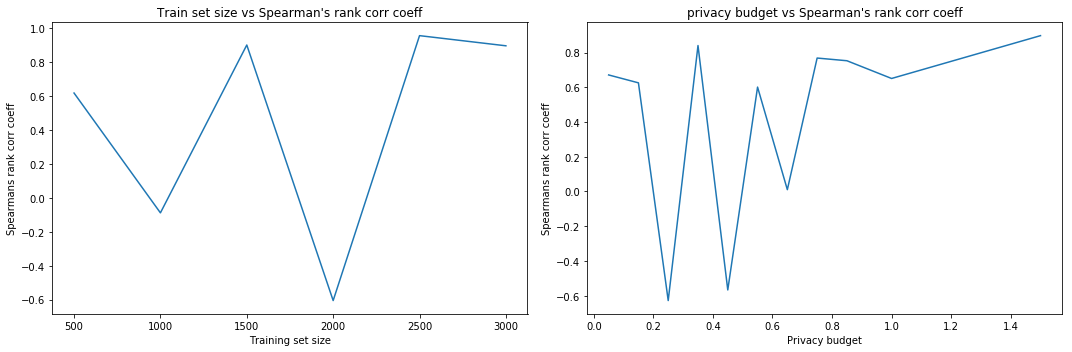

In [167]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab
from scipy.stats import spearmanr

n = 4000
d = 5
k = 5
eps = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1, 1.5]
pts = 10
jump = 500

X, y = make_regression(n_samples = n, n_features = d, noise=30)

colors = ["blue", "red", "black", "orange", "green"]

y_axis = np.ones((len(eps)))

for eps_idx in range(len(eps)):
    epsilon = eps[eps_idx]
    ans = plotter(X, y, n, d, k, epsilon, jump)
    y_axis[eps_idx] = ans[5][ans.shape[1]-1]
    
#     plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon), errorevery=5)
#     plt.scatter(ans[0], ans[1], color=colors[eps_idx], s=10)
 
# plt.rcParams['figure.figsize'] = (12, 5)
# # plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP", errorevery = 5)
# # plt.scatter(ans[0], ans[3], color=colors[4], s=10)
# plt.ylabel("RMSE")
# pylab.legend(loc='upper right')
# # plt.ylim(-0.1,3)
# plt.title("Train set size vs RMSE for k-fold cross validation")
# plt.show()
plt.rcParams['figure.figsize'] = (15, 5)

plt.subplot(1,2,1)
plt.xlabel("Training set size")
plt.ylabel("Spearmans rank corr coeff")
plt.title("Train set size vs Spearman's rank corr coeff")
plt.plot(ans[0], ans[5])

plt.subplot(1,2,2)
plt.plot(eps, y_axis)
plt.xlabel("Privacy budget")
plt.ylabel("Spearmans rank corr coeff")
plt.title("privacy budget vs Spearman's rank corr coeff")
plt.tight_layout()
plt.show()


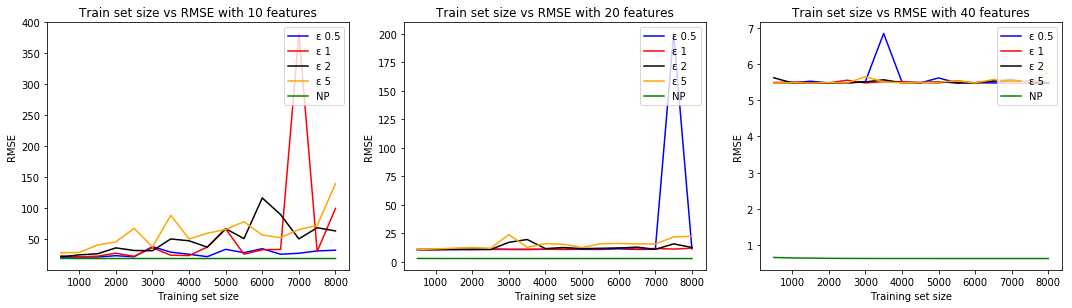

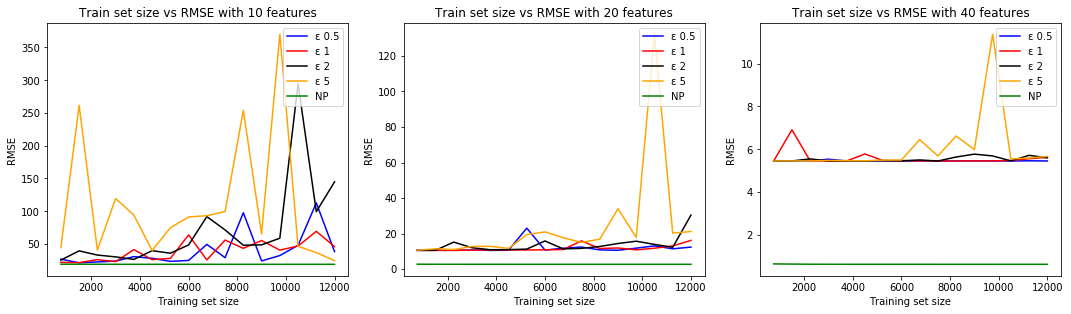

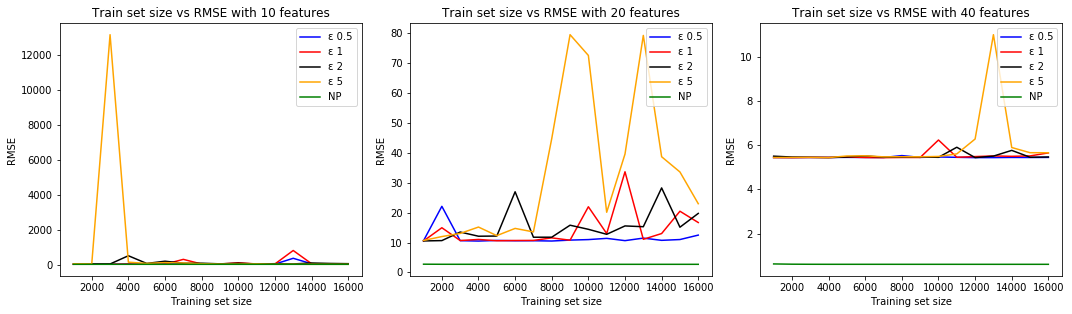

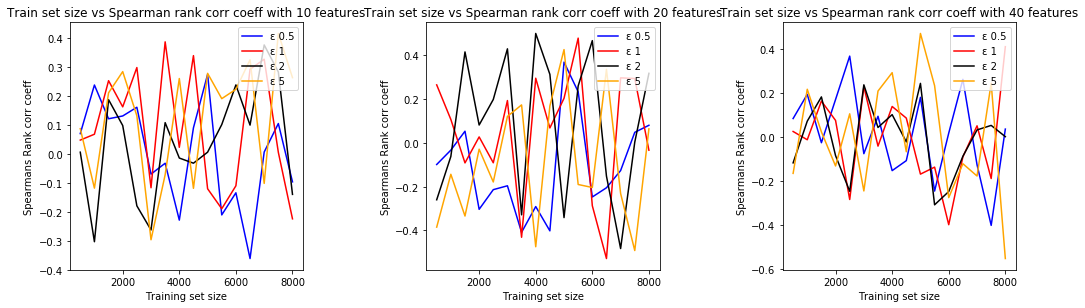

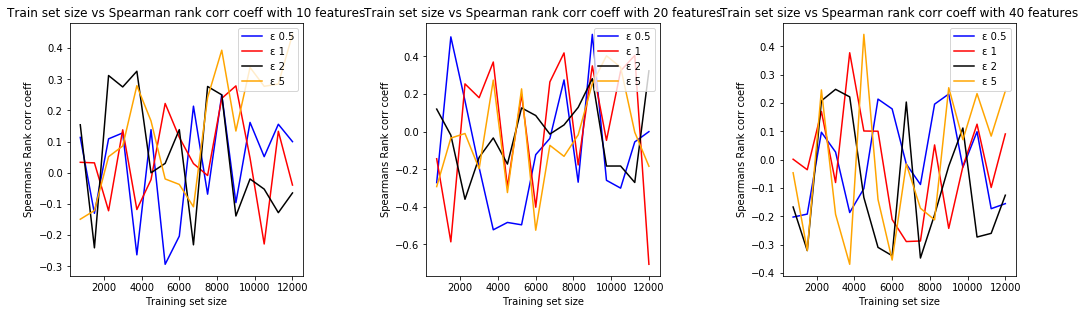

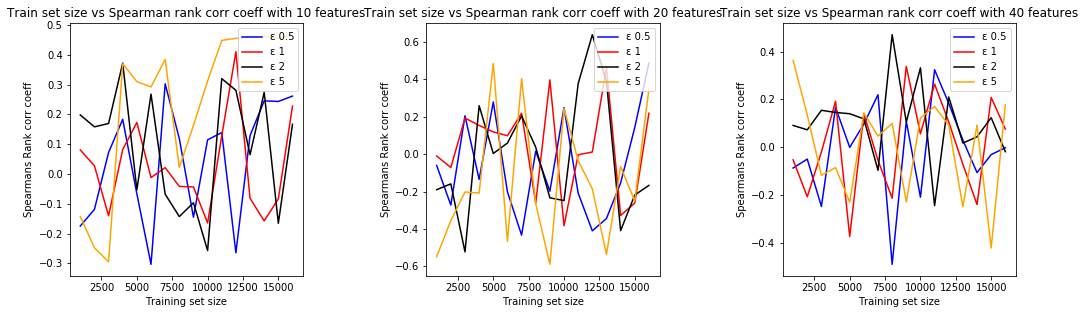

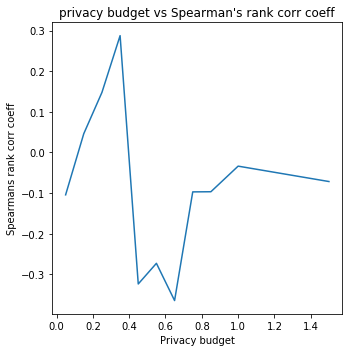

In [168]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import make_regression
import math
from sklearn.preprocessing import normalize
import pylab

entries = [10000, 15000, 20000]
features = [10, 20, 40]
k = 5
eps = [0.5, 1, 2, 5]
plotnum = 1
pts = 20

X, y = make_regression(n_samples = entries[len(entries)-1], n_features = features[len(features)-1], noise=20)

colors = ["blue", "red", "black", "orange", "green"]

x_priv_plots_without_DR = np.ones((0,pts))
y_priv_plots_without_DR = np.ones((0,pts))

for i in range(len(entries)):
    n = entries[i]
    jump = math.floor(n/pts)
    for j in range(len(features)):
        d = features[j]
        plt.rcParams['figure.figsize'] = (15, 12)
        plt.subplot(len(entries),len(features),plotnum)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = plotter(X, y, n, d, k, epsilon, jump)
            
            if x_priv_plots_without_DR.shape[0] == 0:
                x_priv_plots_without_DR = ans[0]
                y_priv_plots_without_DR = ans[1]
                
            else:
                x_priv_plots_without_DR = np.append(arr=x_priv_plots_without_DR, values=ans[0], axis=0)
                y_priv_plots_without_DR = np.append(arr=y_priv_plots_without_DR, values=ans[1], axis=0)
            
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
            
        x_priv_plots_without_DR = np.append(arr=x_priv_plots_without_DR, values=ans[0], axis=0)
        y_priv_plots_without_DR = np.append(arr=y_priv_plots_without_DR, values=ans[3], axis=0)
        
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with " + str(d) + " features")
        plotnum = plotnum+1
    plt.tight_layout()
    plt.show()


plotnum = 1
for i in range(len(entries)):
    n = entries[i]
    jump = math.floor(n/pts)
    for j in range(len(features)):
        d = features[j]
        plt.rcParams['figure.figsize'] = (15, 12)
        plt.subplot(len(entries),len(features),plotnum)
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = plotter(X, y, n, d, k, epsilon, jump)
            
            plt.errorbar(ans[0], ans[5], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon))
        
        plt.xlabel("Training set size")
        plt.ylabel("Spearmans Rank corr coeff")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs Spearman rank corr coeff with " + str(d) + " features")
        plotnum = plotnum+1
    plt.tight_layout()
    plt.show()
    
plt.rcParams['figure.figsize'] = (5, 5)
plotnum = 1
eps = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 1, 1.5]

for eps_idx in range(len(eps)):
    epsilon = eps[eps_idx]
    ans = plotter(X, y, n, d, k, epsilon, jump)
    y_axis[eps_idx] = ans[5][ans.shape[1]-1]

plt.plot(eps, y_axis)
plt.xlabel("Privacy budget")
plt.ylabel("Spearmans rank corr coeff")
plt.title("privacy budget vs Spearman's rank corr coeff")
plt.tight_layout()
plt.show()

eps = [0.5, 1, 2, 5]

In [30]:
x_priv_plots_without_DR = x_priv_plots_without_DR.reshape(len(features)*len(entries)*(1+len(eps)), len(ans[0]))
y_priv_plots_without_DR = y_priv_plots_without_DR.reshape(len(features)*len(entries)*(1+len(eps)), len(ans[0]))
print(x_priv_plots_without_DR.shape)
print(y_priv_plots_without_DR.shape)

(45, 16)
(45, 16)


# Implement PCA

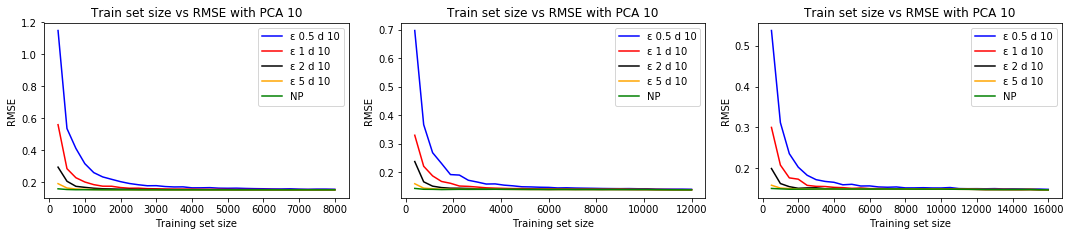

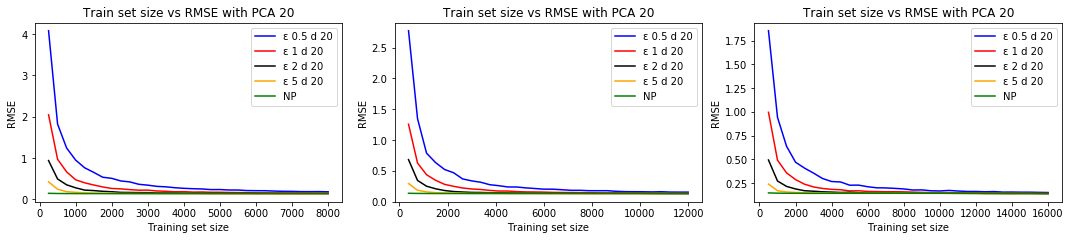

ValueError: n_components=50 must be between 0 and min(n_samples, n_features)=40 with svd_solver='full'

In [25]:
from sklearn.decomposition import PCA

def getPCA(d, X):
    pca = PCA(n_components=d)
    x_pca = pca.fit_transform(X)
    return x_pca

reduced_d = [10, 20, 50, 80]
plotnum = 1

x_priv_plots_PCA = np.ones((0, pts))
y_priv_plots_PCA = np.ones((0, pts))
pts = 40

for i in range(len(reduced_d)):
    d = reduced_d[i]   
    x_pca = getPCA(d, X)
    for j in range(len(entries)):
        n = entries[j]
        jump = math.floor(n/pts)
        plt.rcParams['figure.figsize'] = (15, 12)
        plt.subplot(len(reduced_d),len(entries),plotnum)
        
        for eps_idx in range(len(eps)):
            epsilon = eps[eps_idx]
            ans = plotter(x_pca, y, n, d, k, epsilon, jump)
#             if x_priv_plots_PCA.shape[0] == 0:
#                 x_priv_plots_PCA = ans[0]
#                 y_priv_plots_PCA = ans[1]
                
#             else:
#                 x_priv_plots_PCA = np.append(arr=x_priv_plots_PCA, values=ans[0], axis=0)
#                 y_priv_plots_PCA = np.append(arr=y_priv_plots_PCA, values=ans[1], axis=0)
    
            plt.errorbar(ans[0], ans[1], color=colors[eps_idx], ecolor=colors[eps_idx], capsize=3, label='ε '+str(epsilon)+ " d "+str(d))
 
#         x_priv_plots_PCA = np.append(arr=x_priv_plots_PCA, values=ans[0], axis=0)
#         y_priv_plots_PCA = np.append(arr=y_priv_plots_PCA, values=ans[3], axis=0)
        
        plt.errorbar(ans[0], ans[3], color=colors[4], ecolor=colors[4], capsize=3, label="NP")
        plt.xlabel("Training set size")
        plt.ylabel("RMSE")
        pylab.legend(loc='upper right')
        plt.title("Train set size vs RMSE with PCA " + str(d))
        plotnum = plotnum+1
        
    plt.tight_layout()
    plt.show()

# x_priv_plots_PCA = x_priv_plots_PCA.reshape(len(reduced_d)*len(entries)*(1+len(eps)), len(ans[0]))
# y_priv_plots_PCA = y_priv_plots_PCA.reshape(len(reduced_d)*len(entries)*(1+len(eps)), len(ans[0]))
# print(x_priv_plots_PCA.shape)
# print(y_priv_plots_PCA.shape)

# Dimensionality reduction with VAE

In [ ]:
# import tensorflow as tf
# from sklearn.datasets import make_regression
# import numpy as np
# import matplotlib.pyplot as plt
# import pandas as pd
# from sklearn.datasets import make_regression
# import math
# from sklearn.preprocessing import normalize
# import pylab

# X,y = make_regression(n_samples = 10000, n_features=100, noise=0)

# # Parameters for Neural Networks
# learning_param = 0.00001
# epochs = 100
# batch_size = 50

# initial_dimension = 100
# # encoder/decoder dimension
# NN_dimension = 50

# # z dimension - reduce features to:
# latent_variable_dimension = 10

# # Xavier initialisation 
# def xavier(input_shape):
#   val = tf.random_normal(shape = input_shape, stddev = 1./tf.sqrt(input_shape[0]/2.))
#   return val


# #Weight and bias dictionaries

# weight = {  "encoder_weights": tf.Variable(xavier([initial_dimension, NN_dimension])),
#             "mean_weights": tf.Variable(xavier([NN_dimension, latent_variable_dimension])),
#             "std_weights": tf.Variable(xavier([NN_dimension, latent_variable_dimension])),
#             "decoder_weights": tf.Variable(xavier([latent_variable_dimension, NN_dimension])),
#             "output_weights": tf.Variable(xavier([NN_dimension, initial_dimension]))
#          }

# bias = {    "encoder_bias": tf.Variable(xavier([NN_dimension])),
#             "mean_bias": tf.Variable(xavier([latent_variable_dimension])),
#             "std_bias": tf.Variable(xavier([latent_variable_dimension])),
#             "decoder_bias": tf.Variable(xavier([NN_dimension])),
#             "output_bias": tf.Variable(xavier([initial_dimension]))
#        }


# #Encoder Section

# input_X = tf.placeholder(tf.float32, shape = [None, initial_dimension])
# encoder_layer = tf.add(tf.matmul(input_X, weight["encoder_weights"]), bias["encoder_bias"])
# # Apply non linearity - could be sigmoid or tanh or something else
# encoder_layer = tf.nn.tanh(encoder_layer)

# mean_layer = tf.add(tf.matmul(encoder_layer, weight["mean_weights"]), bias["mean_bias"])
# std_layer = tf.add(tf.matmul(encoder_layer, weight["std_weights"]), bias["std_bias"])

# # Reparametrization trick
# epsilon = tf.random_normal(tf.shape(std_layer), dtype = tf.float32, mean = 0.0, stddev = 1.0)
# latent_layer = mean_layer + tf.exp(0.5*std_layer)*epsilon

# # Decoder Section

# decoder_layer = tf.add(tf.matmul(latent_layer, weight["decoder_weights"]), bias["decoder_bias"])
# decoder_layer = tf.nn.tanh(decoder_layer)

# # Output

# output_layer = tf.add(tf.matmul(decoder_layer, weight["output_weights"]), bias["output_bias"])
# output_layer = tf.nn.sigmoid(output_layer)


# #DEFINING LOSS FUNCTION
# # Total Loss = alpha*reconstruction_loss or data_fidelity_loss + beta*KL_divergence_loss
# # alpha and beta = 1 for VAE
# def loss_function(original_X, reconstructed_X):
  
#   # Reconstruction loss
#   # Reconstruction loss = - sum(x*log(X) + (1-x) log(1-X))
  
#   reconst_loss = original_X*tf.log(1e-10 + reconstructed_X) + (1-original_X)*tf.log(1e-10 + 1 - reconstructed_X)
#   reconst_loss = tf.reduce_sum(reconst_loss, 1)
  
#   # KL Divergence loss
#   # KL_loss = 0.5*sum(e^std + mean^2 - 1 - std)
#   KL_div_loss = 1 + std_layer - tf.exp(std_layer) - tf.square(mean_layer)
#   KL_div_loss = -0.5 * tf.reduce_sum(KL_div_loss, 1)
  
#   alpha = 1
#   beta = 1
#   network_loss = tf.reduce_mean(alpha*reconst_loss + beta*KL_div_loss)
#   return network_loss


# loss_value = loss_function(input_X, output_layer)
# optimizer = tf.train.AdamOptimizer(learning_param).minimize(loss_value)

  
# # Initialize all the variables
# init = tf.global_variables_initializer()

# #Start session
# sess = tf.Session()
# # tf.test.is_gpu_available()

# # Run initializer
# sess.run(init)
    
# for epoch in range(epochs):

#     # Loop over all batches
#     for i in range(200):

#       x_batch = X[i*batch_size: (i+1)*batch_size]
#       _, c = sess.run([optimizer, loss_value], feed_dict={input_X: x_batch})

#     # Display logs per epoch step
#     if epoch % 10 == 0:
#         print("Epoch: ", '%02d' % (epoch + 1), "cost = ", "{:.9f}".format(c))
# print("Optimization Finished!")

# # Autoencoder_output = sess.run(Encoder_op, feed_dict={X: inputData})
# # inputData_ae_nl, outputData_ae_nl = normalizeData(Autoencoder_output, outputData, n, d)

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

initial_dim = 100
intermediate_dim = 50
latent_dim = 10

batch_size = 128
epochs = 50


def z_sampling(args):

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


input_X = Input(shape=(initial_dim, ), name='encoder_input')

# Encoder
x = Dense(intermediate_dim)(input_X)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Z Sampling using reparametrization trick
z = Lambda(z_sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(input_X, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder

latent_inputs = Input(shape=(latent_dim,), name='z_sample')
x = Dense(intermediate_dim)(latent_inputs)
output_X = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, output_X, name='decoder')
decoder.summary()

# instantiate VAE model
output_X = decoder(encoder(input_X)[2])
vae = Model(input_X, output_X, name='vae_mlp')


MSE = True
tr_size = math.floor(4*n/5)
# print(tr_size)
x_train = np.asarray(X[:tr_size])
y_train = np.asarray(y[:tr_size])
x_test = np.asarray(X[tr_size:])
y_test = np.asarray(y[tr_size:])


models = (encoder, decoder)
test_data = (x_test, y_test)

# VAE loss = mse_loss or reconst_loss + kl_loss
if MSE:
    reconstruction_loss = mse(input_X, output_X)
else:
    reconstruction_loss = binary_crossentropy(input_X, output_X)

# reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)

kl_loss = -0.5 * K.sum(kl_loss, axis=-1)
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()
vae.fit(x_train,epochs=epochs,batch_size=batch_size,validation_data=(x_test, None))


z_gen = encoder.predict(np.asarray(X))
z_gen = np.asarray(z_gen)
z_generated = z_gen[2]
print(z_generated.shape)
print(len(z_generated))
# z_vae = []
# for i in range(len(z_generated)):
#     z_vae.append(z_generated[i])

jump = math.floor(n/20)
ans_VAE_e05_d10 = plotter(z_generated, y, n, 10, k, 0.5, jump)
ans_VAE_e1_d10 = plotter(z_generated, y, n, 10, k, 1, jump)


# Plotting


In [ ]:
plt.subplot(1,3,1)
plt.rcParams['figure.figsize'] = (20, 5)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e1[0], ans_withoutDR_e1[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="dashed")

plt.errorbar(ans_PCA_e05_d10[0], ans_PCA_e05_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="solid")
plt.errorbar(ans_PCA_e05_d10[0], ans_PCA_e05_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="solid")
plt.errorbar(ans_PCA_e1_d10[0], ans_PCA_e1_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and PCA")
# plt.show()

plt.subplot(1,3,2)
plt.rcParams['figure.figsize'] = (20, 5)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[1], color="red", ecolor="red", capsize=3, label="e0.5 d100 no DR", ls="dashed")
plt.errorbar(ans_withoutDR_e1[0], ans_withoutDR_e1[1], color="blue", ecolor="blue", capsize=3, label="e1 d100 no DR", ls="dashed")

plt.errorbar(ans_VAE_e05_d10[0], ans_VAE_e05_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e05_d10[0], ans_VAE_e05_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e1_d10[0], ans_VAE_e1_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 VAE", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction and VAE")
# plt.show()

plt.subplot(1,3,3)
plt.rcParams['figure.figsize'] = (20, 5)
plt.errorbar(ans_withoutDR_e05[0], ans_withoutDR_e05[3], color="green", ecolor="green", capsize=3, label="NP d100 no DR", ls="dashed")

plt.errorbar(ans_PCA_e05_d10[0], ans_PCA_e05_d10[3], color="black", ecolor="black", capsize=3, label="NP d10 PCA", ls="solid")
plt.errorbar(ans_PCA_e05_d10[0], ans_PCA_e05_d10[1], color="orange", ecolor="orange", capsize=3, label="e0.5 d10 PCA", ls="solid")
plt.errorbar(ans_PCA_e1_d10[0], ans_PCA_e1_d10[1], color="purple", ecolor="purple", capsize=3, label="e1 d10 PCA", ls="solid")

plt.errorbar(ans_VAE_e05_d10[0], ans_VAE_e05_d10[3], color="cyan", ecolor="cyan", capsize=3, label="NP d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e05_d10[0], ans_VAE_e05_d10[1], color="brown", ecolor="brown", capsize=3, label="e0.5 d10 VAE", ls="solid")
plt.errorbar(ans_VAE_e1_d10[0], ans_VAE_e1_d10[1], color="magenta", ecolor="magenta", capsize=3, label="e1 d10 VAE", ls="solid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
pylab.legend(loc='upper right')
plt.title("Train set size vs RMSE with 100 features - no Dim. Reduction NP(green) + VAE + PCA")
plt.tight_layout()
plt.show()

In [3]:
import tensorflow as tf
tf.test.is_gpu_available()

InternalError: cudaGetDevice() failed. Status: CUDA driver version is insufficient for CUDA runtime version

(10000, 100)


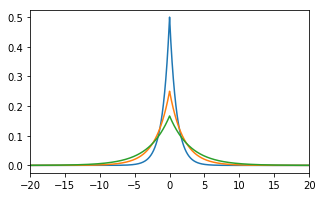

In [44]:
import matplotlib.pyplot as plt
import numpy as np
print(X.shape)
plt.rcParams['figure.figsize'] = (5, 3)
e = 1
loc=0.0
scale=1/e
u = np.random.laplace(loc=0.0, scale=1/e, size=10)
x = np.arange(-1000., 1000., .01)
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.xlim(-20, 20)
plt.plot(x, pdf)

scale = 2/e
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)

scale = 3/e
pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
plt.plot(x, pdf)